# Imports

In [206]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Helper Functions

In [207]:
def getRelativeStockData(ticker, start, end="2024-2-2", interval="1d"):
    data = yf.download(ticker, start=start, end=end, interval=interval)

    # Making it relative to the previous data point with 1% = 0.01
    # All in a pandas dataframe

    # Only use the close price
    data = data["Close"]
    
    data = data.pct_change().dropna()
    data = data.reset_index()
    data = data.rename(columns={"index": "Date"})


    return data


def scrollData(data, contextWindow=10, solutionWindow=3):
    # Scrolling through the data and returning the context window and the solution window
    # Columns: Date, Solution1, Solution2, ..., Context0, Context-1, Context-2, ...

    # Create the columns for the context and solution windows
    for i in range(solutionWindow):
        data[f"Solution{i+1}"] = data["Close"].shift(-i)
    for i in range(contextWindow):
        data[f"Context{-i}"] = data["Close"].shift(i)

    # Drop the NaN values
    data = data.dropna()

    # Drop the Close column
    data = data.drop(columns=["Close"])

    # Fix the index
    data = data.reset_index(drop=True)

    return data


def unrelativizeDataArray(data):
    # Unrelativize the data
    # This is done by multiplying the previous data point with the current data point
    # This is done for all values except the first

    processedData = data.copy()

    # Its an array in an array for some reason (with predictions)
    if len(processedData) == 1:
        processedData = processedData[0]

    # Make the base (first value) 0
    processedData[0] = 0

    # Loop through the data and unrelativize it
    for i in range(len(processedData)):
        if i != 0:
            processedData[i] = (processedData[i] + 1) * (processedData[i-1] + 1) - 1

    return processedData

# Prepare Data

In [216]:
# Get Data for AAPL
data = getRelativeStockData("AAPL", "2018-1-1", interval="1d")

# Some Parameters
contextWindow=1000
solutionWindow=10

# Scroll the data
data = scrollData(data, contextWindow=contextWindow, solutionWindow=solutionWindow)

# Split the data into training and testing data
train, test = train_test_split(data, test_size=0.1)

# Columns for the context and solution windows
contextColumns = [f"Context{-i}" for i in range(contextWindow)]
solutionColumns = [f"Solution{i+1}" for i in range(solutionWindow)]

# Split X and y
X_train = train[contextColumns]
y_train = train[solutionColumns]

X_test = test[contextColumns]
y_test = test[solutionColumns]

[*********************100%***********************]  1 of 1 completed


/var/folders/4f/1_x0p0d95fg8j5jdc43b1s9c0000gn/T/ipykernel_27899/2400067373.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"Context{-i}"] = data["Close"].shift(i)
/var/folders/4f/1_x0p0d95fg8j5jdc43b1s9c0000gn/T/ipykernel_27899/2400067373.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"Context{-i}"] = data["Close"].shift(i)
/var/folders/4f/1_x0p0d95fg8j5jdc43b1s9c0000gn/T/ipykernel_27899/2400067373.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

# Train the Model

In [209]:
# Making the MLP model
# model = MLPRegressor(hidden_layer_sizes=(1), max_iter=100, verbose=True)
model = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100, 100), activation='relu', solver='adam', alpha=0.0001, learning_rate='constant', learning_rate_init=0.001, verbose=True)


# Train the model
model.fit(X_train, y_train)

Iteration 1, loss = 0.02293331
Iteration 2, loss = 0.00887342
Iteration 3, loss = 0.00331436
Iteration 4, loss = 0.00170451
Iteration 5, loss = 0.00095821
Iteration 6, loss = 0.00109124
Iteration 7, loss = 0.00110178
Iteration 8, loss = 0.00077364
Iteration 9, loss = 0.00052320
Iteration 10, loss = 0.00044060
Iteration 11, loss = 0.00045166
Iteration 12, loss = 0.00047057
Iteration 13, loss = 0.00045114
Iteration 14, loss = 0.00040327
Iteration 15, loss = 0.00036250
Iteration 16, loss = 0.00035277
Iteration 17, loss = 0.00035750
Iteration 18, loss = 0.00035236
Iteration 19, loss = 0.00034119
Iteration 20, loss = 0.00033479
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100, 100), verbose=True)

# Test the Model

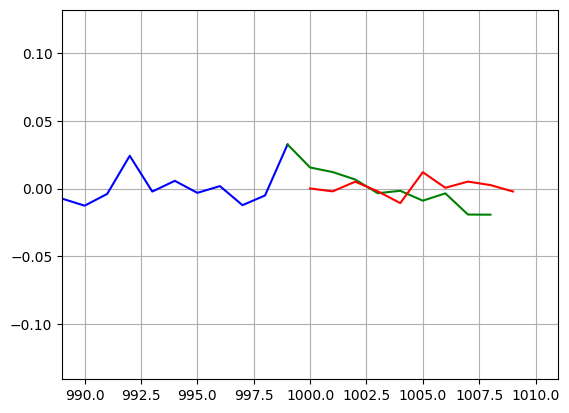

In [217]:
# Get the x'th data point for testing
whereToPredict = 1 # points before end
contextToPredict = data[contextColumns][-1-whereToPredict:-whereToPredict]
solutionToPredict = data[solutionColumns][-1-whereToPredict:-whereToPredict]

# Make Prediction on that data point
predicitons = model.predict(contextToPredict)


# Make the data usefull (reversing etc.)
plottedContext = contextToPredict.values[0][::-1].reshape(-1, 1)
plottedSolution = solutionToPredict.values.reshape(-1, 1)
plottedPredictions = predicitons.reshape(-1, 1)

# Plot the data in green, red, blue
plt.plot(plottedContext, "blue")

x_values = range(contextWindow - 1, contextWindow + len(plottedSolution) - 1)
plt.plot(x_values, plottedSolution, "green")

x_values = range(contextWindow, contextWindow + len(plottedPredictions))
plt.plot(x_values, plottedPredictions, "red")

# Set the x-axis range to zoom from ... to ...
plt.xlim(len(unrelativizeDataArray(plottedContext))-len(unrelativizeDataArray(plottedPredictions))*1.1, len(unrelativizeDataArray(plottedContext)) + len(unrelativizeDataArray(plottedPredictions)) * 1.1)

plt.grid()

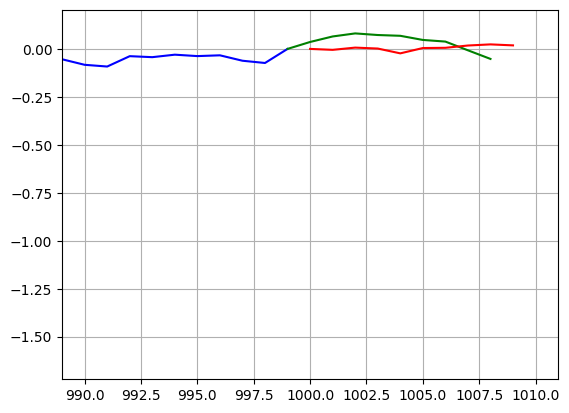

In [218]:
# Plot the data in green, red, blue
plt.plot(unrelativizeDataArray(plottedContext) - unrelativizeDataArray(plottedContext)[-1], "blue")

x_values = range(contextWindow - 1, contextWindow + len(plottedSolution) - 1)
y_values = unrelativizeDataArray(plottedSolution) * (unrelativizeDataArray(plottedContext)[-1] + 1)
plt.plot(x_values, y_values , "green")

x_values = range(contextWindow, contextWindow + len(plottedPredictions))
y_values = unrelativizeDataArray(plottedPredictions) * (unrelativizeDataArray(plottedContext)[-1] + 1)
plt.plot(x_values, y_values, "red")

# Set the x-axis range to zoom from ... to ...
xlim = len(unrelativizeDataArray(plottedContext))-len(unrelativizeDataArray(plottedPredictions))*1.1, len(unrelativizeDataArray(plottedContext)) + len(unrelativizeDataArray(plottedPredictions)) * 1.1
plt.xlim(xlim)

# Set the y-axis range to zoom from the minimum to the maximum of all values visible in the plot
allValuesInPlot = np.append(unrelativizeDataArray(plottedPredictions), unrelativizeDataArray(plottedSolution))
allValuesInPlot = np.append(allValuesInPlot, (unrelativizeDataArray(plottedContext) - unrelativizeDataArray(plottedContext)[-1])[int(xlim[0]):int(xlim[1])])

# plt.ylim(min(allValuesInPlot)*1.1, max(allValuesInPlot)*1.1)

plt.grid()

# Calculating some fancy stats

In [212]:
# Average percent error calculation
# First we'll calculate the percentage error between all the predictions and the actual values
# Then we'll calculate the average of those percentage errors

# Average absolute error calculation
# First we'll calculate the absolute error between all the predictions and the actual values
# Then we'll calculate the average of those absolute errors

avgPercentErrors = []
avgAbsoluteErrors = []


for i in range(len(plottedPredictions)):
    percentError = abs((plottedPredictions[i] - plottedSolution[i]) / plottedSolution[i]) # 1% = 0.01
    avgPercentErrors.append(percentError)

    absoluteError = abs(plottedPredictions[i] - plottedSolution[i])
    avgAbsoluteErrors.append(absoluteError)

In [213]:
# Calculate the average of the errors
avgPercentError = (sum(avgPercentErrors) / len(avgPercentErrors))[0]
avgAbsoluteError = (sum(avgAbsoluteErrors) / len(avgAbsoluteErrors))[0]

In [214]:
# Sum up with print statements
print(f"Average percent error: {round(avgPercentError*100, 2)}%")
print(f"Average absolute error: {round(avgAbsoluteError*100, 2)}%")

Average percent error: 140.13%
Average absolute error: 1.13%


# Some actually professional measures

In [215]:
# Predict the Testing Data
predicitons = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, predicitons)

# Print the mean squared error
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0002997298191492528
